# Homework 2


In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import os

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset



In [2]:
os.environ["http_proxy"]="http://proxy.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy.alcf.anl.gov:3128"
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


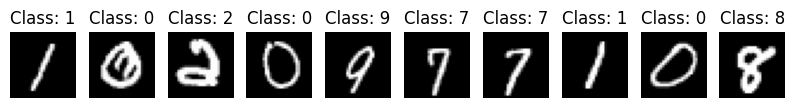

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [6]:
def dataload(batch_size):
    # The dataloader makes our dataset iterable
    global train_dataloader, val_dataloader
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

# Linear Model

In [7]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [8]:
def optimize(mmodel, lr):
    global model, loss_fn, optimizer
    model = mmodel
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(mmodel.parameters(), lr=lr)

# Learning




In [9]:
def train_one_epoch(dataloader, mmodel, loss_fn, optimizer):
    mmodel.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = mmodel(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, mmodel, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    mmodel.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = mmodel(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 10
dataload(128)
optimize(LinearClassifier(), 0.01)
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.9111943543752035, accuracy: 83.05624999999999
Epoch 1: training loss: 0.6825984609921774, accuracy: 85.34583333333333
Epoch 2: training loss: 0.5894201465447744, accuracy: 86.34166666666667
Epoch 3: training loss: 0.5369964554309845, accuracy: 87.0125
Epoch 4: training loss: 0.5026086479028066, accuracy: 87.52291666666666
Epoch 5: training loss: 0.47793039194742837, accuracy: 87.89375
Epoch 6: training loss: 0.4591449507077535, accuracy: 88.16874999999999
Epoch 7: training loss: 0.4442385677496592, accuracy: 88.47500000000001
Epoch 8: training loss: 0.4320400929450989, accuracy: 88.75833333333333
Epoch 9: training loss: 0.4218178584178289, accuracy: 88.94583333333334
CPU times: user 35min 23s, sys: 44.6 s, total: 36min 8s
Wall time: 1min 8s


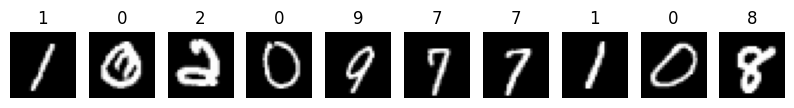

In [12]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
model.eval()
batch = next(iter(train_dataloader))
predictions = model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

In [13]:
acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.4129, validation accuracy: 88.73%


In [14]:
def show_failures(mmodel, dataloader, maxtoshow=10):
    mmodel.eval()
    batch = next(iter(dataloader))
    predictions = mmodel(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


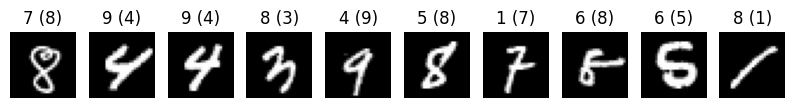

In [15]:
show_failures(model, val_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model (without dropout)
## smaller batch size, with higher learning rate and number of epochs renders more accurate model

In [16]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [17]:
%%time
# learning rate = 0.001
epochs = 10
batch = [64, 128, 256]
for batch_size in batch:
    dataload(batch_size)
    optimize(NonlinearClassifier(), 0.001)
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        print(f"Batch {batch_size}: Epoch {j}: training loss: {loss}, accuracy: {acc}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Batch 64: Epoch 0: training loss: 2.2909581457773847, accuracy: 14.34375
Batch 64: Epoch 1: training loss: 2.274615571339925, accuracy: 28.75625
Batch 64: Epoch 2: training loss: 2.2521023995081584, accuracy: 35.69166666666666
Batch 64: Epoch 3: training loss: 2.218477717399597, accuracy: 40.6625
Batch 64: Epoch 4: training loss: 2.1661203502019246, accuracy: 43.84166666666667
Batch 64: Epoch 5: training loss: 2.086271086851756, accuracy: 46.014583333333334
Batch 64: Epoch 6: training loss: 1.972094872156779, accuracy: 49.80416666666667
Batch 64: Epoch 7: training loss: 1.8221691762606302, accuracy: 54.57083333333333
Batch 64: Epoch 8: training loss: 1.6394705872535706, accuracy: 59.12291666666667
Batch 64: Epoch 9: training loss: 1.436692041873932, accuracy: 63.993750000000006
Validation loss: 1.4342, validation accuracy: 64.50%
Batch 128: Epoch 0: training loss: 2.296887159347534, accuracy: 14.729166666666666
Batch 128: Epoch 1: training loss: 2.287678555170695, accuracy: 20.1875
Bat

In [18]:
%%time
# learning rate = 0.01
epochs = 10
batch = [64, 128, 256]
for batch_size in batch:
    dataload(batch_size)
    optimize(NonlinearClassifier(), 0.01)
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        print(f"Batch {batch_size}: Epoch {j}: training loss: {loss}, accuracy: {acc}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Batch 64: Epoch 0: training loss: 1.1593120844364166, accuracy: 72.72916666666667
Batch 64: Epoch 1: training loss: 0.5331098214785258, accuracy: 85.41041666666666
Batch 64: Epoch 2: training loss: 0.4150465724865596, accuracy: 88.53750000000001
Batch 64: Epoch 3: training loss: 0.3674412407875061, accuracy: 89.70833333333333
Batch 64: Epoch 4: training loss: 0.3389191430211067, accuracy: 90.49166666666667
Batch 64: Epoch 5: training loss: 0.3181038615604242, accuracy: 91.1125
Batch 64: Epoch 6: training loss: 0.3009657977918784, accuracy: 91.51458333333333
Batch 64: Epoch 7: training loss: 0.2863326441248258, accuracy: 91.89583333333333
Batch 64: Epoch 8: training loss: 0.27329413228233657, accuracy: 92.25208333333333
Batch 64: Epoch 9: training loss: 0.2613119367559751, accuracy: 92.50208333333333
Validation loss: 0.2541, validation accuracy: 92.48%
Batch 128: Epoch 0: training loss: 2.081579999923706, accuracy: 52.81875
Batch 128: Epoch 1: training loss: 1.2075724356969197, accuracy

In [19]:
%%time
# learning rate = 0.1
epochs = 10
batch = [64, 128, 256]
for batch_size in batch:
    dataload(batch_size)
    optimize(NonlinearClassifier(), 0.1)
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        print(f"Batch {batch_size}: Epoch {j}: training loss: {loss}, accuracy: {acc}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Batch 64: Epoch 0: training loss: 0.28263897730906806, accuracy: 91.91666666666667
Batch 64: Epoch 1: training loss: 0.18583668438096843, accuracy: 94.6
Batch 64: Epoch 2: training loss: 0.1455527552391092, accuracy: 95.775
Batch 64: Epoch 3: training loss: 0.11911415015906096, accuracy: 96.5
Batch 64: Epoch 4: training loss: 0.10412197099874416, accuracy: 96.94166666666668
Batch 64: Epoch 5: training loss: 0.09225917581530908, accuracy: 97.28333333333333
Batch 64: Epoch 6: training loss: 0.0819398913346231, accuracy: 97.50208333333333
Batch 64: Epoch 7: training loss: 0.07417958262190223, accuracy: 97.69166666666666
Batch 64: Epoch 8: training loss: 0.0669130961013337, accuracy: 97.91041666666666
Batch 64: Epoch 9: training loss: 0.06173835796614488, accuracy: 98.09166666666667
Validation loss: 0.1036, validation accuracy: 96.95%
Batch 128: Epoch 0: training loss: 0.37284113057454427, accuracy: 89.375
Batch 128: Epoch 1: training loss: 0.28099387109279633, accuracy: 91.97083333333333


# Multilayer Model (with dropout)

In [20]:
class NonlinearClassifierwd(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [21]:
%%time
# learning rate = 0.001
epochs = 10
batch = [64, 128, 256]
for batch_size in batch:
    dataload(batch_size)
    optimize(NonlinearClassifierwd(), 0.001)
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        print(f"Batch {batch_size}: Epoch {j}: training loss: {loss}, accuracy: {acc}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Batch 64: Epoch 0: training loss: 2.286647445678711, accuracy: 16.177083333333332
Batch 64: Epoch 1: training loss: 2.256421439488729, accuracy: 20.679166666666667
Batch 64: Epoch 2: training loss: 2.21475897248586, accuracy: 28.914583333333333
Batch 64: Epoch 3: training loss: 2.155951996167501, accuracy: 38.9125
Batch 64: Epoch 4: training loss: 2.073151703198751, accuracy: 43.17916666666667
Batch 64: Epoch 5: training loss: 1.9656608859697977, accuracy: 46.14375
Batch 64: Epoch 6: training loss: 1.8384352305730185, accuracy: 51.49583333333333
Batch 64: Epoch 7: training loss: 1.693312808672587, accuracy: 58.2375
Batch 64: Epoch 8: training loss: 1.530898714542389, accuracy: 64.11666666666666
Batch 64: Epoch 9: training loss: 1.3632762495676676, accuracy: 69.05416666666667
Validation loss: 1.3577, validation accuracy: 69.24%
Batch 128: Epoch 0: training loss: 2.297278245925903, accuracy: 14.229166666666668
Batch 128: Epoch 1: training loss: 2.2877099488576254, accuracy: 21.075
Batch 

In [22]:
%%time
# learning rate = 0.01
epochs = 10
batch = [64, 128, 256]
for batch_size in batch:
    dataload(batch_size)
    optimize(NonlinearClassifierwd(), 0.01)
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        print(f"Batch {batch_size}: Epoch {j}: training loss: {loss}, accuracy: {acc}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Batch 64: Epoch 0: training loss: 1.5431170121828715, accuracy: 62.44583333333333
Batch 64: Epoch 1: training loss: 0.6929693332910538, accuracy: 82.625
Batch 64: Epoch 2: training loss: 0.5049266201257706, accuracy: 86.64791666666667
Batch 64: Epoch 3: training loss: 0.42559269990523657, accuracy: 88.44999999999999
Batch 64: Epoch 4: training loss: 0.3801428047617276, accuracy: 89.4625
Batch 64: Epoch 5: training loss: 0.3495293011665344, accuracy: 90.1625
Batch 64: Epoch 6: training loss: 0.32565431874990464, accuracy: 90.69166666666668
Batch 64: Epoch 7: training loss: 0.30586461806297305, accuracy: 91.26875
Batch 64: Epoch 8: training loss: 0.28965063286821047, accuracy: 91.71875
Batch 64: Epoch 9: training loss: 0.2742177993953228, accuracy: 92.10625
Validation loss: 0.2691, validation accuracy: 91.99%
Batch 128: Epoch 0: training loss: 2.10985795211792, accuracy: 50.072916666666664
Batch 128: Epoch 1: training loss: 1.3241064281463624, accuracy: 65.69791666666667
Batch 128: Epoch

In [23]:
%%time
# learning rate = 0.1
epochs = 10
batch = [64, 128, 256]
for batch_size in batch:
    dataload(batch_size)
    optimize(NonlinearClassifierwd(), 0.1)
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        print(f"Batch {batch_size}: Epoch {j}: training loss: {loss}, accuracy: {acc}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Batch 64: Epoch 0: training loss: 0.26769556020696955, accuracy: 92.05833333333334
Batch 64: Epoch 1: training loss: 0.19469764026006062, accuracy: 94.27083333333334
Batch 64: Epoch 2: training loss: 0.15809546986967324, accuracy: 95.32083333333333
Batch 64: Epoch 3: training loss: 0.14378100097427765, accuracy: 95.67708333333333
Batch 64: Epoch 4: training loss: 0.12211739934359987, accuracy: 96.29791666666667
Batch 64: Epoch 5: training loss: 0.11270601808279752, accuracy: 96.73333333333333
Batch 64: Epoch 6: training loss: 0.1028013191272815, accuracy: 96.91666666666666
Batch 64: Epoch 7: training loss: 0.10047984467881421, accuracy: 96.98333333333333
Batch 64: Epoch 8: training loss: 0.08864163094945252, accuracy: 97.33958333333334
Batch 64: Epoch 9: training loss: 0.08338557256261507, accuracy: 97.575
Validation loss: 0.1094, validation accuracy: 96.79%
Batch 128: Epoch 0: training loss: 0.36753988659381864, accuracy: 89.70625
Batch 128: Epoch 1: training loss: 0.26804452133178713